## COVID-19 Country Clustering Analysis

## Importing Relevant Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import gc
import re
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Importing and Merging Datasets for Analysis

The data was aggregated and collected from https://health.google.com/covid-19/open-data/. 
The Google Health COVID-19 Open Data Repository is one of the most comprehensive collections of up-to-date COVID-19-related information. Comprising data from more than 20,000 locations worldwide, it contains a rich variety of data types to help public health professionals, researchers, policymakers and others in understanding and managing the virus.

Datasets will be imported and merged sequentially to optimize memory usage due to the large volume of the datasets.

**Theme of the Paper: Country Performance during Two Years of the Pandemic**

Looking back/contemplating on the country performance during the pandemic and clustering it into several different clusters to draw insights and lessons learned that might be applicable for the future pandemic.

### 0. Preparing Dataset Identifier

In [2]:
index = pd.read_csv('index.csv')
index = index[['country_code','country_name']]
index.rename(columns={'country_code': 'location_key'}, inplace=True)

In [3]:
index = index[index['location_key'].str.len() == 2]
index = index.drop_duplicates()

### **1. Importing and Preparing epidemiology dataset**

In [4]:
# Importing epidemiology dataset
epidemiology = pd.read_csv("epidemiology.csv")

**Checking the epidemiology dataset timeframe**

In [5]:
# Converting date variable into date format
epidemiology['date'] = pd.to_datetime(epidemiology['date'])

The clustering analysis would take scope between the first global pandemic declaration from WHO on March 2020 two years later at March 2022.

**Filtering the dataset to reflect the scope and grouping the epidemiology data based on the location**

In [6]:
# Define the start and end dates
start_date = pd.to_datetime('2020-03-11')
end_date = pd.to_datetime('2022-03-11')

# Filter the DataFrame based on the date range
epidemiology = epidemiology[(epidemiology['date'] >= start_date) & (epidemiology['date'] <= end_date)]

In [7]:
grouped = epidemiology.groupby('location_key')[['cumulative_confirmed', 'cumulative_deceased', 
                                                'cumulative_recovered', 'cumulative_tested']].max()
grouped = grouped.reset_index()

**Filtering to only country level aggregate**

In [8]:
filtered_grouped = grouped[grouped['location_key'].str.len() == 2]

**Handling missing data**

In [9]:
missing_recovered = filtered_grouped[filtered_grouped['cumulative_recovered'].isna()]['location_key']

In [10]:
country_cumulative_recovered = {}

for code in missing_recovered:
    cumulative_recovered = grouped.loc[grouped['location_key'].str.contains('^' + code), 'cumulative_recovered'].sum()
    country_cumulative_recovered[code] = cumulative_recovered

# Convert dictionary to DataFrame
country_cumulative_recovered = pd.DataFrame.from_dict(country_cumulative_recovered, orient='index', columns=['cumulative_recovered'])

In [11]:
missing_tested = filtered_grouped[filtered_grouped['cumulative_tested'].isna()]['location_key']

In [12]:
country_cumulative_tested = {}

for test in missing_tested:
    cumulative_tested = grouped.loc[grouped['location_key'].str.contains('^' + test), 'cumulative_tested'].sum()
    country_cumulative_tested[test] = cumulative_tested

# Convert dictionary to DataFrame
country_cumulative_tested = pd.DataFrame.from_dict(country_cumulative_tested, orient='index', columns=['cumulative_tested'])

**Cleaning epidemiology dataset**

In [13]:
pattern = '^(' + '|'.join(map(re.escape, missing_tested)) + ')'
filtered_grouped = filtered_grouped[~filtered_grouped['location_key'].str.contains(pattern)]

In [14]:
filtered_grouped = filtered_grouped[filtered_grouped['location_key'] != 'EH']

In [15]:
filtered_grouped.drop('cumulative_recovered', axis=1, inplace=True)

In [16]:
filtered_grouped.reset_index()
pd.set_option('display.float_format', '{:.2f}'.format)

In [17]:
country = filtered_grouped

### **2. Merging demographics dataset**

In [18]:
demographics = pd.read_csv("demographics.csv")

In [19]:
country = country.merge(demographics, on='location_key')

In [20]:
columns_to_drop = ['population_largest_city', 'population_clustered', 'population_male', 'population_female',
                   'population_age_00_09', 'population_age_10_19', 'population_age_20_29', 'population_age_30_39',
                   'population_age_40_49', 'population_age_50_59', 'population_age_60_69', 'population_age_70_79',
                   'population_age_80_and_older']

country.drop(columns_to_drop, axis=1, inplace=True)

In [21]:
country.dropna(subset=['population_rural', 'population_urban', 'human_development_index'], inplace=True)

### **3. Merging economy dataset and focusing on variables of interest**

In [22]:
economy = pd.read_csv("economy.csv")

In [23]:
country = country.merge(economy, on='location_key')

In [24]:
country.dropna(subset=['human_capital_index'], inplace=True)

### **4. Merging geography dataset and focusing on variables of interest**

In [25]:
geography = pd.read_csv("geography.csv")

In [26]:
country = country.merge(geography, on='location_key')

In [27]:
columns_to_drop = ['openstreetmap_id', 'elevation_m', 'area_rural_sq_km', 'area_urban_sq_km' ]
country.drop(columns_to_drop, axis=1, inplace=True)

### **5. Merging health dataset and focusing on variables of interest**

In [28]:
health = pd.read_csv("health.csv")

In [29]:
country = country.merge(health, on='location_key')

In [30]:
columns_to_drop = ['hospital_beds_per_1000', 'adult_male_mortality_rate',
                   'infant_mortality_rate', 'adult_female_mortality_rate']
country.drop(columns_to_drop, axis=1, inplace=True)

In [31]:
country.dropna(subset=['smoking_prevalence', 'physicians_per_1000','health_expenditure_usd',
                       'out_of_pocket_health_expenditure_usd'], inplace=True)

### **6. Importing hospitalizations dataset and focusing on variables of interest**

Note that this dataset will not be merged into the main dataset ('country') due to the limited observations. This dataset will later be used to reinforce the analysis on certain cluster.

In [32]:
hospitalizations = pd.read_csv("hospitalizations.csv")

In [33]:
hospitalizations = hospitalizations.groupby('location_key')[['cumulative_hospitalized_patients', 'cumulative_intensive_care_patients', 
                                                'cumulative_ventilator_patients']].max()
hospitalizations = hospitalizations.reset_index()

In [34]:
hosp_country = hospitalizations[hospitalizations['location_key'].str.len() == 2]

In [35]:
chp = hosp_country[hosp_country['cumulative_hospitalized_patients'].isna()]['location_key']

In [36]:
chp_hosp = {}

for cum in chp:
    chp_agg = hospitalizations.loc[hospitalizations['location_key'].str.contains('^' + cum), 'cumulative_hospitalized_patients'].sum()
    chp_hosp[cum] = chp_agg

# Convert dictionary to DataFrame
chp_hosp = pd.DataFrame.from_dict(chp_hosp, orient='index', columns=['chp_agg'])
chp_hosp.reset_index(inplace = True)
chp_hosp.rename(columns={'index': 'location_key'}, inplace=True)

Conclusion1: remove observation with null value in the cumulative_hospitalized_patients variables 

In [37]:
cic = hosp_country[hosp_country['cumulative_intensive_care_patients'].isna()]['location_key']

In [38]:
cic_hosp = {}

for cum in cic:
    cic_agg = hospitalizations.loc[hospitalizations['location_key'].str.contains('^' + cum), 'cumulative_intensive_care_patients'].sum()
    cic_hosp[cum] = cic_agg

# Convert dictionary to DataFrame
cic_hosp = pd.DataFrame.from_dict(cic_hosp, orient='index', columns=['cic_agg'])
cic_hosp.reset_index(inplace = True)
cic_hosp.rename(columns={'index': 'location_key'}, inplace=True)

In [39]:
hosp_country.loc[hosp_country['location_key'] == 'CH', 'cumulative_intensive_care_patients'] = 730

conclusion2: removing all observations with zero value in cumulative_intensive_care_patients columns

In [40]:
cvp = hosp_country[hosp_country['cumulative_ventilator_patients'].isna()]['location_key']

In [41]:
cvp_hosp = {}

for cum in cvp:
    cvp_agg = hospitalizations.loc[hospitalizations['location_key'].str.contains('^' + cum), 'cumulative_ventilator_patients'].sum()
    cvp_hosp[cum] = cvp_agg

# Convert dictionary to DataFrame
cvp_hosp = pd.DataFrame.from_dict(cvp_hosp, orient='index', columns=['cvp_agg'])
cvp_hosp.reset_index(inplace = True)
cvp_hosp.rename(columns={'index': 'location_key'}, inplace=True)

Conclusion3: drop cumulative_ventilator_patients columns

In [42]:
hosp_country.drop('cumulative_ventilator_patients', axis=1, inplace=True)

In [43]:
hosp_country.dropna(subset=['cumulative_hospitalized_patients', 'cumulative_intensive_care_patients'], inplace=True)

**Recombine All Hospitalizations Information**

In [44]:
hospitalizations = hosp_country.merge(cvp_hosp, on='location_key', how='left')

In [45]:
hospitalizations = hospitalizations.merge(chp_hosp, on='location_key', how='left')

In [46]:
hospitalizations = hospitalizations.merge(cic_hosp, on='location_key', how='left')

### **7. Importing government response dataset for country specific intervention analysis**

will only use 'stringency_index' as a proxy for the government response with more in depth analysis after the clustering analysis has been done.

In [47]:
# Importing government response dataset
gov_response = pd.read_csv("oxford-government-response.csv")

In [48]:
# Converting date variable into date format
gov_response['date'] = pd.to_datetime(gov_response['date'])

In [49]:
# Define the start and end dates
start_date = pd.to_datetime('2020-03-11')
end_date = pd.to_datetime('2022-03-11')

# Filter the DataFrame based on the date range
gov_response = gov_response[(gov_response['date'] >= start_date) & (gov_response['date'] <= end_date)]

In [50]:
grouped = gov_response.groupby('location_key').max()
grouped = grouped.reset_index()

In [51]:
gov_response = grouped[grouped['location_key'].str.len() == 2]

In [52]:
gov_response_merge = gov_response[['location_key','stringency_index']]

In [53]:
country = country.merge(gov_response_merge, on='location_key', how='left')

### **8. Importing mobility dataset and focusing on variables of interest**

In [54]:
# Importing mobility dataset
mobility = pd.read_csv("mobility.csv")

In [55]:
# Converting date variable into date format
mobility['date'] = pd.to_datetime(mobility['date'])

In [56]:
# Define the start and end dates
start_date = pd.to_datetime('2020-03-11')
end_date = pd.to_datetime('2022-03-11')

# Filter the DataFrame based on the date range
mobility = mobility[(mobility['date'] >= start_date) & (mobility['date'] <= end_date)]

In [57]:
mob = mobility.groupby('location_key')[['mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy', 
                                                'mobility_parks', 'mobility_transit_stations','mobility_workplaces',
                                       'mobility_residential']].mean()
mob = mob.reset_index()

In [58]:
filtered_mob = mob[mob['location_key'].str.len() == 2]

In [59]:
country = country.merge(filtered_mob, on='location_key')

### 9. Importing weather dataset and focusing on variables of interest**

In [60]:
# Importing mobility dataset
weather = pd.read_csv("weather.csv")

In [61]:
# Converting date variable into date format
weather['date'] = pd.to_datetime(weather['date'])

In [62]:
# Define the start and end dates
start_date = pd.to_datetime('2020-03-11')
end_date = pd.to_datetime('2022-03-11')

# Filter the DataFrame based on the date range
weather = weather[(weather['date'] >= start_date) & (weather['date'] <= end_date)]

In [63]:
wet = weather.groupby('location_key')[['average_temperature_celsius', 'rainfall_mm', 
                                                'dew_point', 'relative_humidity']].mean()
wet = wet.reset_index()

In [64]:
filtered_wet = wet[wet['location_key'].str.len() == 2]

In [65]:
country = country.merge(filtered_wet, on='location_key')

### 10. Normalizing Population Based Data to Total Population

In [66]:
columns_to_divide = ['cumulative_confirmed', 'cumulative_deceased', 
                     'cumulative_tested', 'population_rural', 'population_urban']
country[columns_to_divide] = country[columns_to_divide].div(country['population'], axis=0)

### 11. Dropping Redundant Variables

In [67]:
columns_to_drop = ['population', 'gdp_usd', 'out_of_pocket_health_expenditure_usd', 
                   'dew_point','rainfall_mm']
country.drop(columns_to_drop, axis=1, inplace=True)

### 11. Deleting original dataset to free up memory space

In [68]:
del epidemiology, demographics, economy, geography, health,filtered_grouped, grouped,filtered_mob,mob,wet,filtered_wet

In [69]:
gc.collect();

In [70]:
country.set_index('location_key', inplace=True)

## Building k-means Country Clustering Model

### **1. Preparing the Dataset for Clustering Analysis**

In [71]:
country_cluster = country[['cumulative_confirmed', 'cumulative_deceased', 'cumulative_tested',
       'population_rural', 'population_urban', 'population_density',
       'human_development_index', 'gdp_per_capita_usd', 'human_capital_index','area_sq_km', 'life_expectancy',
       'smoking_prevalence', 'diabetes_prevalence', 'pollution_mortality_rate',
       'comorbidity_mortality_rate', 'nurses_per_1000', 'physicians_per_1000',
       'health_expenditure_usd','stringency_index', 'mobility_retail_and_recreation',
       'mobility_grocery_and_pharmacy', 'mobility_parks',
       'mobility_transit_stations', 'mobility_workplaces',
       'mobility_residential', 'average_temperature_celsius',
       'relative_humidity']]

In [72]:
# Scaling the country data
scaler = preprocessing.StandardScaler()
scaled_country = scaler.fit_transform(country_cluster)
scaled_country= pd.DataFrame(scaled_country)

# Changing the colnames to its original value
scaled_country.columns = country_cluster.columns

# Checking for the scaled data
scaled_country.head()

,cumulative_confirmed,cumulative_deceased,cumulative_tested,population_rural,population_urban,population_density,human_development_index,gdp_per_capita_usd,human_capital_index,area_sq_km,life_expectancy,smoking_prevalence,diabetes_prevalence,pollution_mortality_rate,comorbidity_mortality_rate,nurses_per_1000,physicians_per_1000,health_expenditure_usd,stringency_index,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,average_temperature_celsius,relative_humidity
0,-0.37,-0.84,4.07,-1.01,0.93,-0.25,0.76,1.13,0.37,-0.37,0.47,0.83,2.16,-0.28,-0.04,0.09,0.24,-0.06,0.35,0.07,0.10,-1.08,-0.56,0.22,0.49,1.24,-1.27
1,0.49,1.03,-0.42,-1.24,1.21,-0.57,0.50,-0.42,0.04,0.71,0.28,0.07,-0.42,-0.69,-0.22,-0.60,1.19,-0.08,1.39,-1.41,-0.52,-1.67,-0.54,0.59,0.45,-0.10,-0.77
2,1.66,0.46,5.47,0.31,-0.27,-0.28,1.07,1.52,1.30,-0.37,1.04,0.91,-0.24,-0.85,-1.05,0.40,1.95,1.72,-0.40,-1.08,-0.75,0.48,-0.52,-0.96,-0.20,-1.17,0.70
3,0.01,-0.85,0.21,-0.98,0.93,-0.61,1.28,1.68,1.37,2.68,1.17,-0.69,-0.49,-0.95,-1.48,1.61,0.98,1.92,-0.82,-0.07,-0.38,-0.69,-1.41,-0.09,0.14,0.22,-2.01
4,-0.18,2.38,-0.47,0.78,-0.70,-0.42,-0.13,-0.60,0.09,-0.38,0.39,1.91,0.35,0.08,0.15,0.09,0.00,-0.51,0.64,0.44,0.52,0.10,0.33,0.42,-2.49,-0.89,0.28


### **2. Constructing an Elbow Chart**

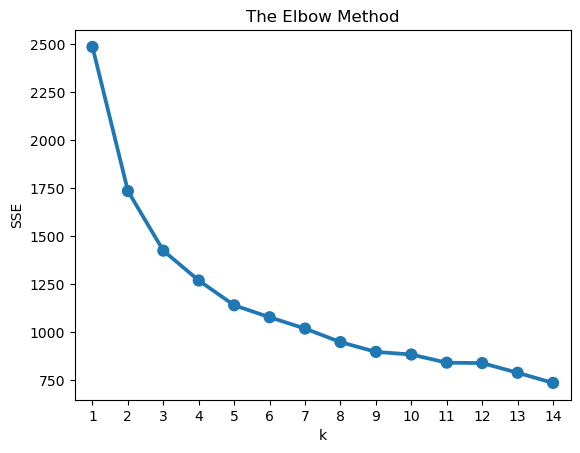

In [73]:
# Initializing empty list for SSE calculation
sse = {}
for k in range(1, 15): 
# Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=296)
# Fit KMeans on the normalized dataset
    kmeans.fit(scaled_country)
    sse[k] = kmeans.inertia_
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')
# Add X-axis label "k"
plt.xlabel('k')
# Add Y-axis label "SSE"
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()));

Looking at the above elbow chart, the  SSE seems to drastically drop when transitioning from k=1 to k=5 while the rest of the k seems only contribute to small decrease in the SSE. Further analysis would need to be done in detail for k=3 to k=5 to check which number of cluster that might be best to describe the country cluster that has clear separation between variables and easy to understand and digging deeper for further analysis.

### 3. Checking for k=3 to k=4 cluster characteristics

In [74]:
# Number of cluster equals to 3
kmeans3 = KMeans(n_clusters=3, random_state=296)
kmeans3.fit(scaled_country)
cluster_labels3 = kmeans3.labels_

k_means3 = scaled_country.assign(Cluster = cluster_labels3)
k_means3.groupby(['Cluster']).agg({
'cumulative_confirmed': ['mean'],
'cumulative_deceased':['mean'],
'cumulative_tested': ['mean'],
'population_rural': ['mean'],
'population_urban': ['mean'],
'population_density': ['mean'],
'human_development_index': ['mean'],
'gdp_per_capita_usd': ['mean'],
'human_capital_index': ['mean'],
'area_sq_km': ['mean'],
'life_expectancy': ['mean'],
'smoking_prevalence': ['mean'],
'diabetes_prevalence': ['mean'],
'pollution_mortality_rate': ['mean'],
'comorbidity_mortality_rate': ['mean'],
'nurses_per_1000': ['mean'],
'physicians_per_1000': ['mean'],
'health_expenditure_usd': ['mean'],
'stringency_index': ['mean'],    
'mobility_retail_and_recreation': ['mean'],
'mobility_grocery_and_pharmacy': ['mean'],
'mobility_parks': ['mean'],
'mobility_transit_stations': ['mean'],
'mobility_workplaces': ['mean'],
'mobility_residential': ['mean'],
'average_temperature_celsius': ['mean'],
'relative_humidity': ['mean','count'],
}).round(2)

cumulative_confirmed cumulative_deceased cumulative_tested  \
                        mean                mean              mean   
Cluster                                                              
0                      -0.87               -0.87             -0.55   
1                      -0.28                0.08             -0.23   
2                       0.86                0.48              0.60   

        population_rural population_urban population_density  \
                    mean             mean               mean   
Cluster                                                        
0                   1.09            -1.13              -0.03   
1                  -0.14             0.16               0.06   
2                  -0.55             0.56              -0.04   

        human_development_index gdp_per_capita_usd human_capital_index  \
                           mean               mean                mean   
Cluster                                                                  
0                         -1.42              -0.80               -1.28   
1                          0.03              -0.33               -0.22   
2                          0.89               0.87                1.07   

        area_sq_km life_expectancy smoking_prevalence diabetes_prevalence  \
              mean            mean               mean                mean   
Cluster                                                                     
0            -0.18           -1.42              -0.77               -0.52   
1            -0.06            0.10              -0.13                0.60   
2             0.18            0.81               0.63               -0.30   

        pollution_mortality_rate comorbidity_mortality_rate nurses_per_1000  \
                            mean                       mean            mean   
Cluster                                                                       
0                           1.37                       0.82           -0.85   
1                          -0.13                       0.10           -0.40   
2                          -0.75                      -0.64            0.98   

        physicians_per_1000 health_expenditure_usd stringency_index  \
                       mean                   mean             mean   
Cluster                                                               
0                     -1.13                  -0.70            -0.29   
1                     -0.22                  -0.43             0.52   
2                      0.96                   0.91            -0.36   

        mobility_retail_and_recreation mobility_grocery_and_pharmacy  \
                                  mean                          mean   
Cluster                                                                
0                                 1.32                          1.06   
1                                -0.59                         -0.38   
2                                -0.23                         -0.29   

        mobility_parks mobility_transit_stations mobility_workplaces  \
                  mean                      mean                mean   
Cluster                                                                
0                 0.19                      1.33                1.26   
1                -0.90                     -0.46               -0.26   
2                 0.84                     -0.37               -0.54   

        mobility_residential average_temperature_celsius relative_humidity  \
                        mean                        mean              mean   
Cluster                                                                      
0                      -0.33                        0.64             -0.47   
1                       0.43                        0.54             -0.15   
2                      -0.24                       -0.99              0.47   

               
        count  
Cluster        
0        

k equals to 3 quick results:

1. cumulative confirmed: nicely split
2. cumulative deceased: very nicely split
3. cumulative tested: nicely split
4. population rural: nicely split
5. population urban: nicely split
6. population density: not nicely split, cluster 0, 1, and 2 has around the same density
7. human development index: very nicely split
8. gdp per capita (USD): nicely split
9. human capital index: very nicely split
10. area sq (km): not nicely split, cluster 0 and 1 has around the same size
11. life expectancy: very nicely split
12. smoking prevalence: very nicely split
13. diabetes prevalence: nicely split
14. pollution mortality rate: very nicely split #proxy to air quality
15. comorbidity mortality rate: very nicely split #proxy to other major disease condition
16. nurses per 1000: very nicely split
17. physicians per 1000: very nicely split
18. health expenditure (USD): very nicely split
19. stringency index: not nicely split, cluster 0 and 2 has around the same stringency index
20. mobility retail and recreation: very nicely split
21. mobility grocery and pharmacy: not nicely split, cluster 1 and 2 has around the same value
22. mobility parks: very nicely split
23. mobility transit stations: nicely split
24. mobility workplaces: nicely split
25. mobility residential: not nicely cluster 0 and 2 has around the same mobility for residential
26. average temperature: not nicely split cluster 1 and 2 has around the same average temperature during the first two years of pandemic
27. relative humidity: nicely split

Tally

Number of nicely split variables: 21 
Number of ambiguous variables: 6

In [75]:
# Number of cluster equals to 4
kmeans4 = KMeans(n_clusters=4, random_state=296)
kmeans4.fit(scaled_country)
cluster_labels4 = kmeans4.labels_

k_means4 = scaled_country.assign(Cluster = cluster_labels4)
k_means4.groupby(['Cluster']).agg({
'cumulative_confirmed': ['mean'],
'cumulative_deceased':['mean'],
'cumulative_tested': ['mean'],
'population_rural': ['mean'],
'population_urban': ['mean'],
'population_density': ['mean'],
'human_development_index': ['mean'],
'gdp_per_capita_usd': ['mean'],
'human_capital_index': ['mean'],
'area_sq_km': ['mean'],
'life_expectancy': ['mean'],
'smoking_prevalence': ['mean'],
'diabetes_prevalence': ['mean'],
'pollution_mortality_rate': ['mean'],
'comorbidity_mortality_rate': ['mean'],
'nurses_per_1000': ['mean'],
'physicians_per_1000': ['mean'],
'health_expenditure_usd': ['mean'],
'mobility_retail_and_recreation': ['mean'],
'mobility_grocery_and_pharmacy': ['mean'],
'mobility_parks': ['mean'],
'mobility_transit_stations': ['mean'],
'mobility_workplaces': ['mean'],
'mobility_residential': ['mean'],
'average_temperature_celsius': ['mean'],
'relative_humidity': ['mean','count'],
}).round(2)

cumulative_confirmed cumulative_deceased cumulative_tested  \
                        mean                mean              mean   
Cluster                                                              
0                      -0.87               -0.87             -0.55   
1                       0.72               -0.02              0.70   
2                       0.94                1.37              0.34   
3                      -0.30               -0.03             -0.23   

        population_rural population_urban population_density  \
                    mean             mean               mean   
Cluster                                                        
0                   1.09            -1.13              -0.03   
1                  -0.86             0.86               0.16   
2                   0.03            -0.02              -0.38   
3                  -0.19             0.21               0.09   

        human_development_index gdp_per_capita_usd human_capital_index  \
                           mean               mean                mean   
Cluster                                                                  
0                         -1.42              -0.80               -1.28   
1                          1.08               1.46                1.20   
2                          0.53              -0.13                0.74   
3                          0.02              -0.32               -0.24   

        area_sq_km life_expectancy smoking_prevalence diabetes_prevalence  \
              mean            mean               mean                mean   
Cluster                                                                     
0            -0.18           -1.42              -0.77               -0.52   
1             0.20            1.07               0.19               -0.22   
2             0.09            0.37               1.36               -0.35   
3            -0.05            0.09              -0.22                0.63   

        pollution_mortality_rate comorbidity_mortality_rate nurses_per_1000  \
                            mean                       mean            mean   
Cluster                                                                       
0                           1.37                       0.82           -0.85   
1                          -0.89                      -1.24            1.30   
2                          -0.46                       0.34            0.43   
3                          -0.13                       0.08           -0.44   

        physicians_per_1000 health_expenditure_usd  \
                       mean                   mean   
Cluster                                              
0                     -1.13                  -0.70   
1                      0.88                   1.60   
2                      0.99                  -0.24   
3                     -0.25                  -0.42   

        mobility_retail_and_recreation mobility_grocery_and_pharmacy  \
                                  mean                          mean   
Cluster                                                                
0                                 1.32                          1.06   
1                                -0.27                         -0.43   
2                                -0.14                         -0.03   
3                                -0.63                         -0.41   

        mobility_parks mobility_transit_stations mobility_workplaces  \
                  mean                      mean                mean   
Cluster                                                                
0                 0.19                      1.33                1.26   
1                 0.71                     -0.65               -0.64   
2                 0.89                      0.07               -0.32   
3                -0.95                     -0.49               -0.28   

        mobility_residential average_temperature_celsius relative_

k equals to 4 quick results:

1. cumulative confirmed: nicely split
2. cumulative deceased: not nicely split
3. cumulative tested: nicely split
4. population rural: nicely split
5. population urban: nicely split
6. population density: not nicely split
7. human development index: very nicely split
8. gdp per capita (USD): nicely split
9. human capital index: very nicely split
10. area sq (km): not nicely split, cluster 0 and 1 has around the same size
11. life expectancy: very nicely split
12. smoking prevalence: very nicely split
13. diabetes prevalence: not nicely split
14. pollution mortality rate: very nicely split #proxy to air quality
15. comorbidity mortality rate: very nicely split #proxy to other major disease condition
16. nurses per 1000: very nicely split
17. physicians per 1000: not nicely split
18. health expenditure (USD): very nicely split
19. stringency index: not nicely split, cluster 0 and 2 has around the same stringency index
20. mobility retail and recreation: not nicely split
21. mobility grocery and pharmacy: not nicely split, cluster 1 and 2 has around the same value
22. mobility parks: not nicely split
23. mobility transit stations: not nicely split
24. mobility workplaces: not nicely split
25. mobility residential: nicely split
26. average temperature: not nicely split
27. relative humidity: nicely split

Tally

Number of nicely split variables: 15 
Number of ambiguous variables: 12

In [76]:
# Number of cluster equals to 5
kmeans5 = KMeans(n_clusters=5, random_state=296)
kmeans5.fit(scaled_country)
cluster_labels5 = kmeans5.labels_

k_means5 = scaled_country.assign(Cluster = cluster_labels5)
k_means5.groupby(['Cluster']).agg({
'cumulative_confirmed': ['mean'],
'cumulative_deceased':['mean'],
'cumulative_tested': ['mean'],
'population_rural': ['mean'],
'population_urban': ['mean'],
'population_density': ['mean'],
'human_development_index': ['mean'],
'gdp_per_capita_usd': ['mean'],
'human_capital_index': ['mean'],
'area_sq_km': ['mean'],
'life_expectancy': ['mean'],
'smoking_prevalence': ['mean'],
'diabetes_prevalence': ['mean'],
'pollution_mortality_rate': ['mean'],
'comorbidity_mortality_rate': ['mean'],
'nurses_per_1000': ['mean'],
'physicians_per_1000': ['mean'],
'health_expenditure_usd': ['mean'],
'mobility_retail_and_recreation': ['mean'],
'mobility_grocery_and_pharmacy': ['mean'],
'mobility_parks': ['mean'],
'mobility_transit_stations': ['mean'],
'mobility_workplaces': ['mean'],
'mobility_residential': ['mean'],
'average_temperature_celsius': ['mean'],
'relative_humidity': ['mean','count'],
}).round(2)

cumulative_confirmed cumulative_deceased cumulative_tested  \
                        mean                mean              mean   
Cluster                                                              
0                      -0.14                0.14             -0.14   
1                      -0.85               -0.87             -0.54   
2                       0.94                1.37              0.34   
3                      -0.85               -0.68             -0.52   
4                       0.72               -0.02              0.70   

        population_rural population_urban population_density  \
                    mean             mean               mean   
Cluster                                                        
0                  -0.59             0.60               0.09   
1                   0.98            -1.03              -0.14   
2                   0.03            -0.02              -0.38   
3                   1.28            -1.24               0.21   
4                  -0.86             0.86               0.16   

        human_development_index gdp_per_capita_usd human_capital_index  \
                           mean               mean                mean   
Cluster                                                                  
0                          0.19              -0.20               -0.12   
1                         -1.40              -0.79               -1.29   
2                          0.53              -0.13                0.74   
3                         -0.87              -0.77               -0.84   
4                          1.08               1.46                1.20   

        area_sq_km life_expectancy smoking_prevalence diabetes_prevalence  \
              mean            mean               mean                mean   
Cluster                                                                     
0            -0.06            0.30              -0.33                0.80   
1            -0.14           -1.48              -0.78               -0.52   
2             0.09            0.37               1.36               -0.35   
3            -0.12           -0.79              -0.14               -0.12   
4             0.20            1.07               0.19               -0.22   

        pollution_mortality_rate comorbidity_mortality_rate nurses_per_1000  \
                            mean                       mean            mean   
Cluster                                                                       
0                          -0.43                      -0.27           -0.35   
1                           1.39                       0.79           -0.86   
2                          -0.46                       0.34            0.43   
3                           0.99                       1.14           -0.77   
4                          -0.89                      -1.24            1.30   

        physicians_per_1000 health_expenditure_usd  \
                       mean                   mean   
Cluster                                              
0                     -0.04                  -0.35   
1                     -1.11                  -0.70   
2                      0.99                  -0.24   
3                     -1.02                  -0.68   
4                      0.88                   1.60   

        mobility_retail_and_recreation mobility_grocery_and_pharmacy  \
                                  mean                          mean   
Cluster                                                                
0                                -0.57                         -0.35   
1                                 1.55                          1.40   
2                                -0.14                         -0.03   
3                                -0.45                         -0.56   
4                                -0.27                         -0.43   

        mobility_parks mobility_transit_stations mobility_workplaces  \
         

k equals to 5 quick results:

1. cumulative confirmed: not nicely split
2. cumulative deceased: not nicely split
3. cumulative tested: not nicely split
4. population rural: nicely split
5. population urban: not nicely split
6. population density: not nicely split
7. human development index: nicely split
8. gdp per capita (USD): not nicely split
9. human capital index: nicely split
10. area sq (km): not nicely split
11. life expectancy: not nicely split
12. smoking prevalence: not nicely split
13. diabetes prevalence: not nicely split
14. pollution mortality rate: not nicely split #proxy to air quality
15. comorbidity mortality rate: nicely split #proxy to other major disease condition
16. nurses per 1000: not nicely split
17. physicians per 1000: not nicely split
18. health expenditure (USD): not nicely split
19. stringency index: not nicely split
20. mobility retail and recreation: not nicely split
21. mobility grocery and pharmacy: not nicely split
22. mobility parks: not nicely split
23. mobility transit stations: not nicely split
24. mobility workplaces: not nicely split
25. mobility residential: not nicely split
26. average temperature: not nicely split
27. relative humidity: not nicely split

Tally

Number of nicely split variables: 4  
Number of ambiguous variables: 23

**Based on the cluster analysis above, it is apparent that k equals to 3 yields the best clusters with distinct characteristics**

### Naming the Clusters

### Cluster 0: "Vulnerable Rural Health Deficit"
- This cluster includes countries with a significant rural population, lower economic development, and healthcare vulnerabilities.
- Despite having the lowest cumulative COVID-19 cases, challenges arise due to healthcare deficits and vulnerabilities in rural areas.
- The highest mobility to retail, recreation, grocery, and pharmacy establishments suggests active engagement in these activities, possibly impacting virus transmission.
- Weather conditions display the highest temperature and lowest humidity.

### Cluster 1: "Urban Diabetes Burden & Residential Refuges"
- Countries in this cluster have a moderate distribution of rural and urban populations with a moderate level of development.
- Challenges arise from the highest percentage of people with diabetes, which requires targeted healthcare strategies.
- Mobility patterns indicate lower engagement in non-essential activities and public spaces, but a relatively higher mobility to workplaces and residential areas.
- Weather conditions feature the highest temperature and moderate humidity.

### Cluster 2: "Resilient Urban Health Capitals"
- This cluster consists of countries with high urbanization, strong economic development, and a well-prepared healthcare system.
- They have faced significant epidemiological challenges with the highest cumulative confirmed, deceased, and tested COVID-19 cases.
- The highest human capital index and GDP per capita indicate economic strength and prosperity.
- The highest number of nurses and physicians, along with substantial health expenditure, reflects a well-equipped healthcare workforce and investment in healthcare infrastructure.
- Mobility patterns show moderate mobility to various establishments, with remote work being more prevalent.
- Weather conditions feature the lowest temperature and highest relative humidity.

## Visualizing the Clusters

### 1. Preparing Clustered Datasets for Visualization

In [77]:
# Assigning back the cluster label to country_cluster dataset columns
cluster = country_cluster.assign(cluster = cluster_labels3)
cluster['cluster'] = cluster['cluster'].astype('category')

# Renaming the cluster
cluster['cluster'] = cluster['cluster'].cat.rename_categories({
    0:'Vulnerable Rural Health Deficit',
    1:'Urban Diabetes Burden & Residential Refuges',
    2:'Resilient Urban Health Capitals',
})

In [78]:
cluster.reset_index(inplace=True)

In [79]:
identifier = pd.DataFrame()
identifier[['latitude','longitude']] = country[['latitude','longitude']]
identifier.reset_index(inplace=True)

In [80]:
identifier = identifier.merge(index, on='location_key')

In [81]:
cluster = cluster.merge(identifier, on='location_key')

In [82]:
cluster = cluster.sort_values(by=['cluster', 'country_name'], ascending=[True, True])

In [83]:
desired_columns_order = ['location_key', 'country_name', 'cluster', 'latitude', 'longitude',
                         'cumulative_confirmed', 'cumulative_deceased', 'cumulative_tested',
                         'population_rural', 'population_urban', 'population_density',
                         'human_development_index', 'gdp_per_capita_usd',
                         'human_capital_index', 'area_sq_km', 'life_expectancy',
                         'smoking_prevalence', 'diabetes_prevalence',
                         'pollution_mortality_rate', 'comorbidity_mortality_rate',
                         'nurses_per_1000', 'physicians_per_1000',
                         'health_expenditure_usd', 'stringency_index',
                         'mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy',
                         'mobility_parks', 'mobility_transit_stations', 'mobility_workplaces',
                         'mobility_residential', 'average_temperature_celsius',
                         'relative_humidity']

cluster = cluster.reindex(columns=desired_columns_order)
cluster.reset_index(inplace=True)
cluster.drop('index', axis=1, inplace=True)

### 2. Interactive Scatterplot Between Features

In [84]:
# Create a Dash app
app = dash.Dash(__name__)

# Available columns for X and Y axes (excluding latitude and longitude)
available_columns = [col for col in cluster.columns if col not in ['latitude', 'longitude','location_key','country_name','cluster']]

# Layout of the app
app.layout = html.Div([
    # Dropdown for X axis
    html.Label("Select X-axis:"),
    dcc.Dropdown(
        id='x-axis-dropdown',
        options=[{'label': col, 'value': col} for col in available_columns],
        value=available_columns[0]
    ),
    # Dropdown for Y axis
    html.Label("Select Y-axis:"),
    dcc.Dropdown(
        id='y-axis-dropdown',
        options=[{'label': col, 'value': col} for col in available_columns],
        value=available_columns[1]
    ),
    # Scatter plot
    dcc.Graph(id='scatter-plot'),
])

# Callback to update the scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    Input('x-axis-dropdown', 'value'),
    Input('y-axis-dropdown', 'value')
)
def update_scatter_plot(x_axis_col, y_axis_col):
    fig = px.scatter(
        cluster,
        x=x_axis_col,
        y=y_axis_col,
        color='cluster',
        hover_data=['country_name', x_axis_col, y_axis_col],  # Data shown in hover tooltip
        labels={
            'cluster': 'Cluster',
            'country_name': 'Country',
            x_axis_col: x_axis_col,
            y_axis_col: y_axis_col
        },
        title=f"Scatter plot of {y_axis_col} vs {x_axis_col}",
    )

    # Update axis labels
    fig.update_xaxes(title=x_axis_col)
    fig.update_yaxes(title=y_axis_col)
    
    # Set the legend position to bottom center
    fig.update_layout(legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5))

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8082)


### 3. Cluster Map Distribution

In [85]:
# Create a Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    # Scatter map
    dcc.Graph(id='scatter-map'),
])

# Callback to update the scatter map
@app.callback(
    Output('scatter-map', 'figure'),
    Input('scatter-map', 'clickData')  # Use the click data from the scatter map to highlight the selected cluster
)
def update_scatter_map(click_data):
    selected_cluster = None
    if click_data:
        selected_cluster = click_data['points'][0]['customdata']

    # Scatter map
    map_fig = px.scatter_geo(
        cluster,
        lat='latitude',
        lon='longitude',
        color='cluster',
        hover_data=['country_name', 'cluster'],
        labels={'cluster': 'Cluster'},
        title='Geographical Map with Cluster Count',
        custom_data=['cluster']  # Include the 'cluster' column in the custom data for clickData
    )

    # Update the selected cluster color in the map
    if selected_cluster:
        map_fig.update_traces(selectedpoints=[selected_cluster])

    # Set the legend position to bottom center
    map_fig.update_layout(legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5))

    return map_fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8085)

### 4. Cluster Country Members: Vulnerable Rural Health Deficit

In [86]:
vrhd_cluster = cluster[cluster['cluster'] == 'Vulnerable Rural Health Deficit'][['country_name']]
vrhd_cluster.columns = ['Vulnerable Rural Health Deficit Cluster Country Members']

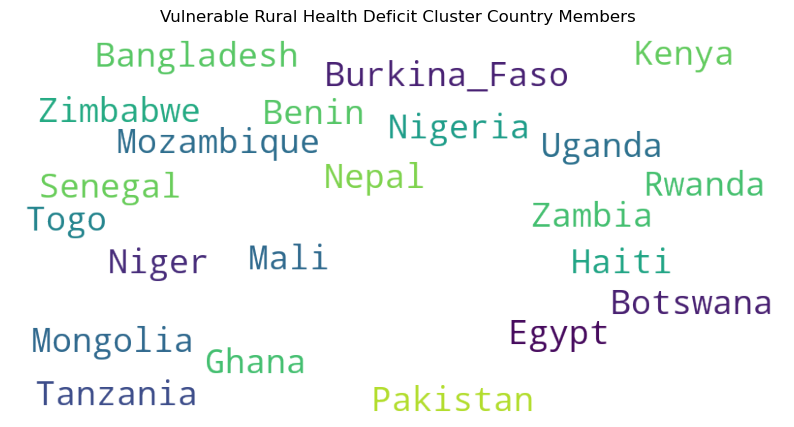

In [87]:
country_names = vrhd_cluster['Vulnerable Rural Health Deficit Cluster Country Members']

# Preprocess the text to replace spaces in multi-word country names with underscores
country_names = country_names.str.replace(' ', '_')

# WordCloud customization
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    contour_color='steelblue',
    contour_width=2,
    max_font_size=35,
    min_word_length=3,
    prefer_horizontal=1.0,
    random_state=42
).generate(' '.join(country_names))

# Preprocess the word cloud image to display underscores as spaces
wordcloud_image = wordcloud.to_image().convert('RGBA')
wordcloud_image_data = wordcloud_image.getdata()
new_image_data = [(r, g, b, a) if r != 255 and g != 255 and b != 255 else (255, 255, 255, 0) for r, g, b, a in wordcloud_image_data]
wordcloud_image.putdata(new_image_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis('off')
plt.title('Vulnerable Rural Health Deficit Cluster Country Members')
plt.show()

### 5. Cluster Country Members: Urban Diabetes Burden and Residential Refuges

In [88]:
udbrr_cluster = cluster[cluster['cluster'] == 'Urban Diabetes Burden & Residential Refuges'][['country_name']]
udbrr_cluster.columns = ['Urban Diabetes Burden and Residential Refuges']

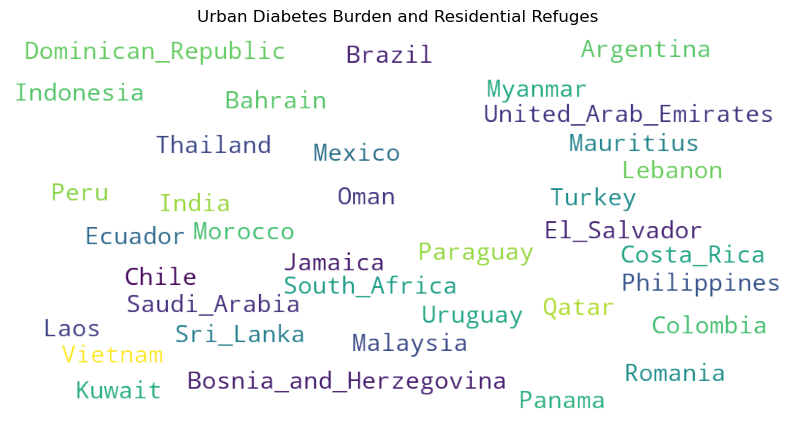

In [89]:
country_names = udbrr_cluster['Urban Diabetes Burden and Residential Refuges']

# Preprocess the text to replace spaces in multi-word country names with underscores
country_names = country_names.str.replace(' ', '_')

# WordCloud customization
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    contour_color='steelblue',
    contour_width=1,
    max_font_size=25,
    min_word_length=3,
    prefer_horizontal=1.0,
    random_state=42
).generate(' '.join(country_names))

# Preprocess the word cloud image to display underscores as spaces
wordcloud_image = wordcloud.to_image().convert('RGBA')
wordcloud_image_data = wordcloud_image.getdata()
new_image_data = [(r, g, b, a) if r != 255 and g != 255 and b != 255 else (255, 255, 255, 0) for r, g, b, a in wordcloud_image_data]
wordcloud_image.putdata(new_image_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis('off')
plt.title('Urban Diabetes Burden and Residential Refuges')
plt.show()

### 6. Cluster Country Members: Resilient Urban Health Capitals

In [90]:
ruhc_cluster = cluster[cluster['cluster'] == 'Resilient Urban Health Capitals'][['country_name']]
ruhc_cluster.columns = ['Resilient Urban Health Capitals']

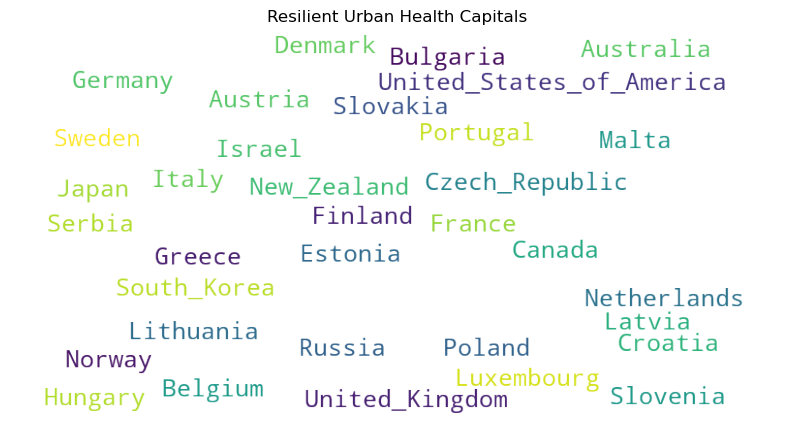

In [91]:
country_names = ruhc_cluster['Resilient Urban Health Capitals']

# Preprocess the text to replace spaces in multi-word country names with underscores
country_names = country_names.str.replace(' ', '_')

# WordCloud customization
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    contour_color='steelblue',
    contour_width=1,
    max_font_size=25,
    min_word_length=3,
    prefer_horizontal=1.0,
    random_state=42
).generate(' '.join(country_names))

# Preprocess the word cloud image to display underscores as spaces
wordcloud_image = wordcloud.to_image().convert('RGBA')
wordcloud_image_data = wordcloud_image.getdata()
new_image_data = [(r, g, b, a) if r != 255 and g != 255 and b != 255 else (255, 255, 255, 0) for r, g, b, a in wordcloud_image_data]
wordcloud_image.putdata(new_image_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis('off')
plt.title('Resilient Urban Health Capitals')
plt.show()